In [48]:
import numpy as np

def Round(number: float, precision: int = 4) -> float:
    factor = 10 ** precision
    return round(float(number) * factor) / factor

def MakeVectors(*args) -> np.ndarray:
    return np.array(object=args)

def DotProduct(matrix: np.ndarray, vector: np.ndarray) -> np.ndarray:
    return np.dot(matrix, vector)

# =============================================================================

def TransitionMatrix(matrix: list) -> np.ndarray:
    return MakeVectors(*matrix)

def PeopleVector(people_industry: int, people_academia: int) -> np.ndarray:
    return MakeVectors(people_industry, people_academia)

# =============================================================================

def CalculatePeopleDistribution(percent: float, total_people: int) -> int:
    return percent * total_people, (1 - percent) * total_people

def CalculatePeopleInitialState(
    total_people: int, percentage_industry: float = None,  percentage_academia: float = None, 
) -> np.ndarray:

    if percentage_industry is not None:
        people_industry, people_academia = CalculatePeopleDistribution(percentage_industry, total_people)
        return PeopleVector(people_industry, people_academia)

    elif percentage_academia is not None:
        people_academia, people_industry = CalculatePeopleDistribution(percentage_academia, total_people)
        return PeopleVector(people_industry, people_academia)
    
    else:
        raise ValueError("Either percentage_industry or percentage_academia must be provided.")

def CalculatePeopleNextYear(transition_matrix: np.ndarray, people: np.ndarray) -> np.ndarray:
    return DotProduct(transition_matrix, people)

# =============================================================================

def UnpackData(history: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X_axis = history[:, 0]
    Y_axis_industry = history[:, 1]
    Y_axis_academia = history[:, 2]
    return X_axis, Y_axis_industry, Y_axis_academia

# =============================================================================

def FindChangeYears(people_history: list[tuple[int, np.ndarray]]) -> list[int]:
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    leader_array = np.sign(Y_axis_industry - Y_axis_academia)
    change_indices = np.where(leader_array[:-1] != leader_array[1:])[0]
    change_years = X_axis[change_indices + 1]
    return change_years.tolist()

# =============================================================================

def SimulateYears(
    initial_year: int, period_of_time: int,
    people: np.ndarray, transition_matrix: np.ndarray, 
    total_people: int, percentage_industry: float,
    step: int = 1,
) -> np.ndarray:

    history = []
    
    start = initial_year
    stop = initial_year + period_of_time
    
    # Vector Structure: [percentage_industry, total_people, year, people_industry, people_academia]
    # history.append([Round(percentage_industry), total_people, start, Round(people[0]), Round(people[1])])
    history.append([percentage_industry, total_people, start, people[0], people[1]])

    for year in range(start + 1, stop + 1, step):
        people = CalculatePeopleNextYear(transition_matrix, people)
        history.append([percentage_industry, total_people, year, people[0], people[1]])

    return np.array(history, dtype=object)

def Simulation(
    total_people: int,
    initial_year: int,
    period_of_time: int,
    transition_matrix: np.ndarray,
    percentage_people_industry: float,

    qnt_sample_total_people: int = 5,
    step_sample_total_people: int = 10_000,

    qnt_sample_percentage_people_industry: int = 5,
    step_sample_percentage_people_industry: float = 0.1,
) -> np.ndarray:
    
    all_results = []

    for i in range(qnt_sample_total_people):
        total_people_i = total_people + i * step_sample_total_people

        for j in range(qnt_sample_percentage_people_industry):
            percentage_people_industry_j = percentage_people_industry + j * step_sample_percentage_people_industry
            
            people = CalculatePeopleInitialState(
                total_people=total_people_i, 
                percentage_industry=percentage_people_industry_j,
            )

            peopleHistory = SimulateYears(
                people=people,
                initial_year=initial_year,
                period_of_time=period_of_time,
                transition_matrix=transition_matrix,
                
                total_people=total_people_i, # Pass total_people here
                percentage_industry=percentage_people_industry_j, # Pass percentage here
            )

            all_results.append(peopleHistory)

    return all_results



In [49]:
T = [
    [0.99, 0.2], 
    [0.01, 0.8],
]

transitionMatrix = TransitionMatrix(matrix=T)

In [73]:
totalPeople = 10_000
percentagePeopleIndustry = 0.1

initialYear = 2025
periodOfTime = 100
finalYear = initialYear + periodOfTime

qntSampleTotalPeople = 8
stepSampleTotalPeople = 10_000

qntSamplePercentagePeopleIndustry = 2
stepSamplePercentagePeopleIndustry = 0.8



In [ ]:

Responses = Simulation(
    
    # Given parameters:
    total_people = totalPeople,
    initial_year = initialYear,
    period_of_time = periodOfTime,
    transition_matrix = transitionMatrix,
    percentage_people_industry = percentagePeopleIndustry,

    # Sampling parameters:
    # 1. Vary total people:
    qnt_sample_total_people = qntSampleTotalPeople,
    step_sample_total_people = stepSampleTotalPeople,
    
    # 2. Vary initial percentage of people in industry:
    qnt_sample_percentage_people_industry=qntSamplePercentagePeopleIndustry,
    step_sample_percentage_people_industry=stepSamplePercentagePeopleIndustry,
)


In [ ]:
def GetTicks(initial_value: float, final_value: float, num_ticks: int = 21, dtype: object = int) -> np.ndarray:
    return np.linspace(initial_value, final_value, num_ticks, dtype=dtype)

def GetMinMaxValues(*args: list[float], delta_up: float = 1.1, delta_down: float = 0.8) -> tuple[float, float]:
    return min(min(arg) for arg in args) * delta_down, max(max(arg) for arg in args) * delta_up

def GetGraphicParameters(
    people_history: list[tuple[int, np.ndarray]],
    initial_year: int, period_of_time: int,
) -> dict[str, object]:
    
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    Y_min, Y_max = GetMinMaxValues(Y_axis_industry, Y_axis_academia)
    
    return X_axis, Y_axis_industry, Y_axis_academia, {
        'Y_min': Y_min, 'Y_max': Y_max,
        'X_ticks': GetTicks(initial_value = initial_year, final_value = initial_year + period_of_time), 
        'Y_ticks': GetTicks(initial_value=Y_min, final_value=Y_max, dtype=float), 
    }

def GetMax(Array: list[np.ndarray]) -> tuple[list[float], list[float]]:
    return max(Array)

def GetMin(Array: list[np.ndarray]) -> tuple[list[float], list[float]]:
    return min(Array)



In [76]:
AllMaximus, AllMinimus = [], []

for response in Responses:
    u, v = response[:, -2], response[:, -1]
    AllMaximus.append(max(GetMax(u), GetMax(v)))
    AllMinimus.append(min(GetMin(u), GetMin(v)))

Maximus, Minimus = max(AllMaximus), min(AllMinimus)
Maximus, Minimus


(np.float64(76190.47619023353), np.float64(476.190476220807))

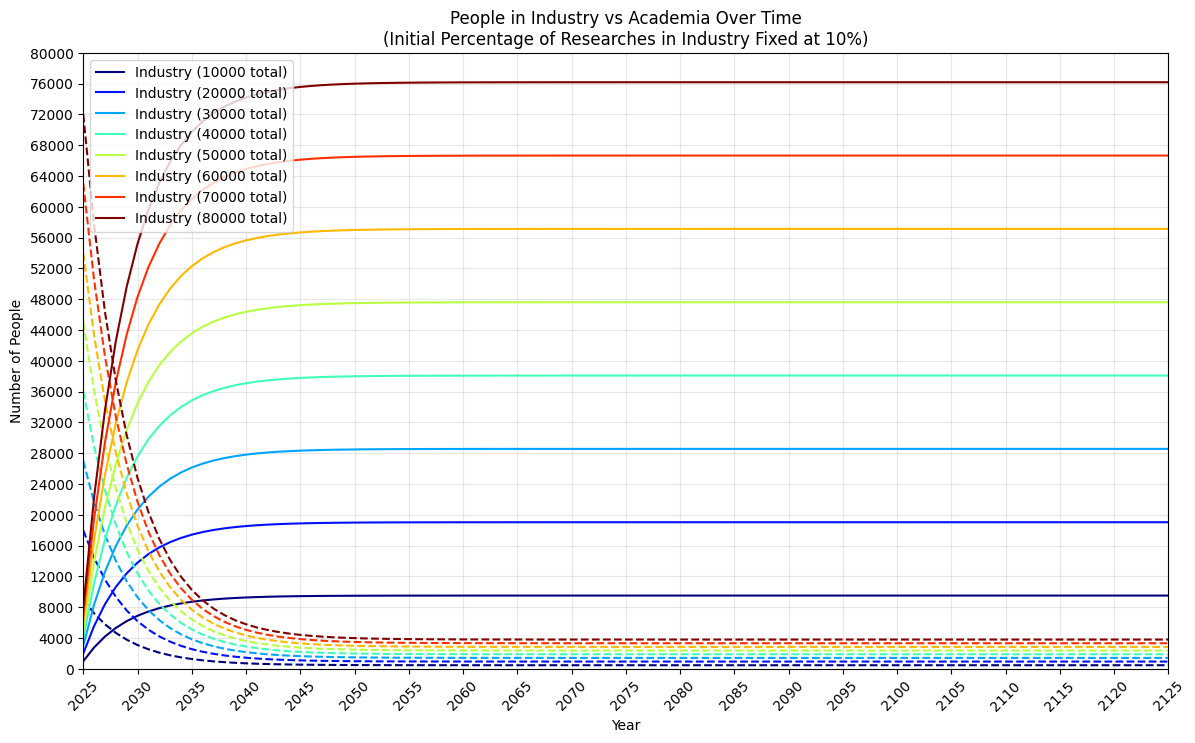

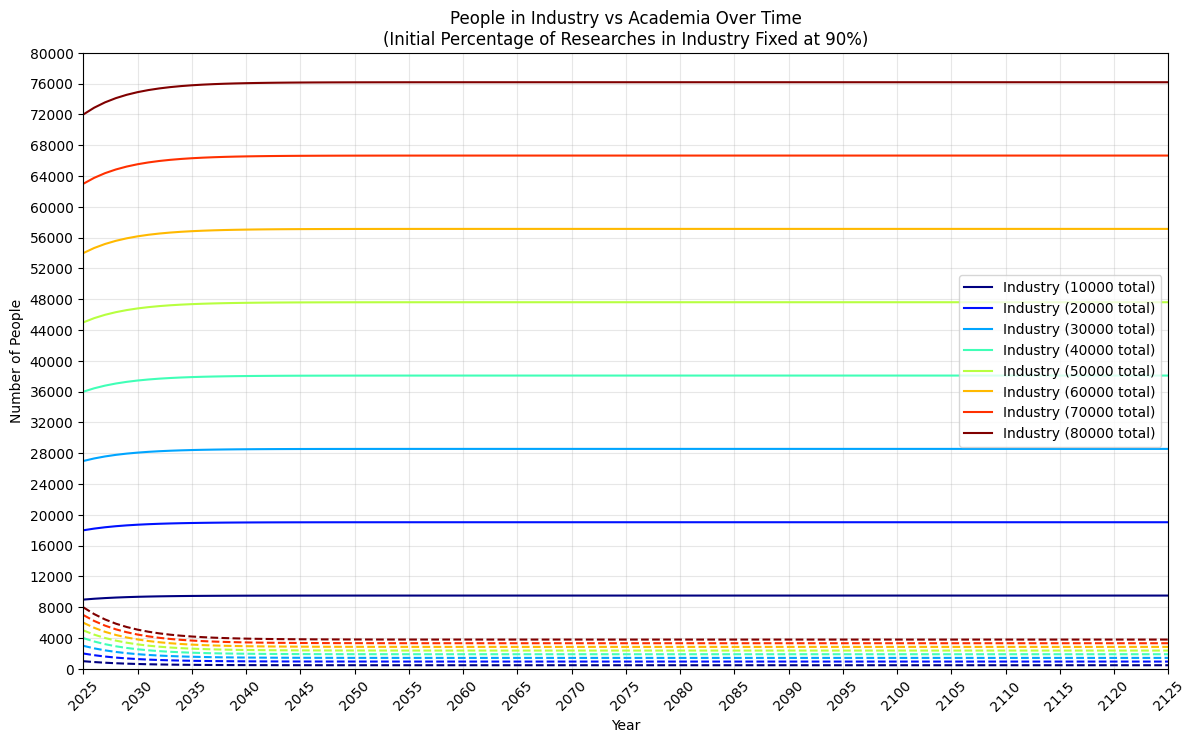

In [79]:
import matplotlib.pyplot as plt

def PlotByFixedPercentage(responses, percentage_index: int):
    plt.figure(figsize=(14, 8))

    # Flatten the list of arrays into a single 2D array
    data_flat = np.concatenate(responses, axis=0) 
    
    # Get the specific percentage to filter by
    target_percentage = np.unique(data_flat[:, 0])[percentage_index]

    # Filter data for the current percentage
    data_at_percentage = data_flat[data_flat[:, 0] == target_percentage]
    
    # Get unique total people counts and create a color map
    total_people_counts = np.unique(data_at_percentage[:, 1])
    colors = plt.cm.jet(np.linspace(0, 1, len(total_people_counts)))

    # Plot each simulation run with a unique color
    for i, total_people in enumerate(total_people_counts):
        
        # Filter data for the current total people count
        current_data = data_at_percentage[data_at_percentage[:, 1] == total_people]

        # Unpack the data
        years = current_data[:, 2]
        industry = current_data[:, 3]
        academia = current_data[:, 4]

        # Plot Industry and Academia on the same axes with the same color
        plt.plot(years, industry, color=colors[i], linestyle='-', label=f'Industry ({total_people:.0f} total)')
        plt.plot(years, academia, color=colors[i], linestyle='--')

    # Set Y-axis from 0 to Maximus with padding
    Y_max_padded = Maximus * 1.05  # Add 5% padding at the top
    Y_ticks = GetTicks(initial_value=0, final_value=Y_max_padded, dtype=float)
    
    # Set X-axis ticks
    X_ticks = GetTicks(initial_value=years[0], final_value=years[-1])
    
    plt.ylim(0, Y_max_padded); plt.yticks(Y_ticks)
    plt.xlim(years[0], years[-1]); plt.xticks(X_ticks, rotation=45)
    
    plt.title(f'People in Industry vs Academia Over Time\n(Initial Percentage of Researches in Industry Fixed at {target_percentage:.0%})')
    plt.xlabel('Year'); plt.ylabel('Number of People')
    plt.legend(); plt.grid(alpha=0.3); plt.show()

# Plot for the 3rd percentage sample (30% initial)
PlotByFixedPercentage(Responses, percentage_index=0)
# Plot for the 9th percentage sample (90% initial)
PlotByFixedPercentage(Responses, percentage_index=1)


In [80]:
# Vector Structure: 
# [percentage_industry, total_people, year, people_industry, people_academia]
# Responses[-3]


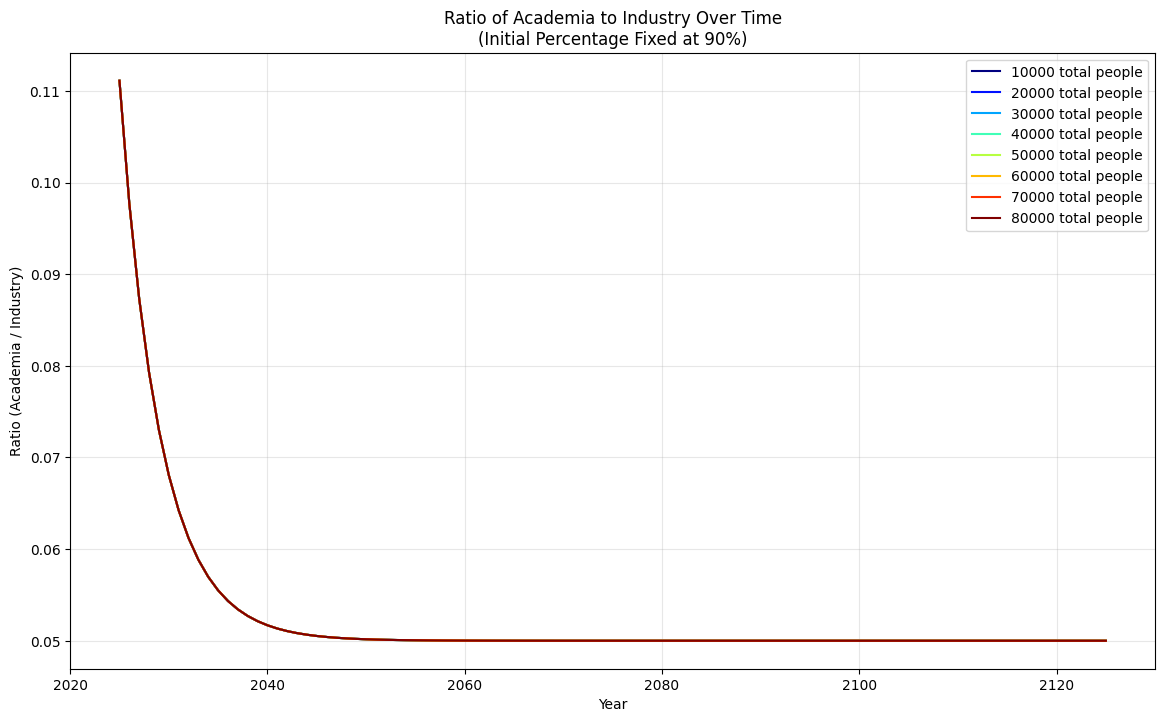

{10000: 0.05000000000334398, 20000: 0.05000000000334398, 30000: 0.050000000003343974, 40000: 0.05000000000334398, 50000: 0.050000000003343974, 60000: 0.050000000003343974, 70000: 0.05000000000334399, 80000: 0.05000000000334398}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def PlotRatiosByFixedPercentage(responses, percentage_index: int):
    plt.figure(figsize=(14, 8))

    # Flatten the list of arrays into a single 2D array
    data_flat = np.concatenate(responses, axis=0) 
    
    # Get the specific percentage to filter by
    target_percentage = np.unique(data_flat[:, 0].astype(float))[percentage_index]

    # Filter data for the current percentage
    data_at_percentage = data_flat[data_flat[:, 0].astype(float) == target_percentage]
    
    # Get unique total people counts and create a color map
    total_people_counts = np.unique(data_at_percentage[:, 1].astype(float))
    colors = plt.cm.jet(np.linspace(0, 1, len(total_people_counts)))

    # Plot each simulation run with a unique color
    for i, total_people in enumerate(total_people_counts):
        
        # Filter data for the current total people count
        current_data = data_at_percentage[data_at_percentage[:, 1].astype(float) == total_people]

        # Unpack the data
        years = current_data[:, 2].astype(float)
        industry = current_data[:, 3].astype(float)
        academia = current_data[:, 4].astype(float)

        # Calculate the ratio and handle division by zero
        ratio = academia / industry
        ratio = np.nan_to_num(ratio, nan=0, posinf=0) # Replace inf with 0, as it happens at year 0

        # Plot the ratio on the same axes with a unique color
        plt.plot(years, ratio, color=colors[i], linestyle='-', label=f'{total_people:.0f} total people')
        
    plt.title(f'Ratio of Academia to Industry Over Time\n(Initial Percentage Fixed at {target_percentage:.0%})')
    plt.xlabel('Year'); plt.ylabel('Ratio (Academia / Industry)')
    plt.legend(); plt.grid(alpha=0.3); plt.show()


def CalculateFinalRatios(responses, percentage_index: int):
    # Flatten the list of arrays into a single 2D array
    data_flat = np.concatenate(responses, axis=0) 
    
    # Get the specific percentage to filter by
    target_percentage = np.unique(data_flat[:, 0].astype(float))[percentage_index]

    # Filter data for the current percentage
    data_at_percentage = data_flat[data_flat[:, 0].astype(float) == target_percentage]
    
    # Get unique total people counts
    total_people_counts = np.unique(data_at_percentage[:, 1].astype(float))

    final_ratios = {}
    for total_people in total_people_counts:
        # Get the final row for this simulation
        final_state = data_at_percentage[data_at_percentage[:, 1].astype(float) == total_people][-1]
        
        academia = final_state[4].astype(float)
        industry = final_state[3].astype(float)
        
        ratio = academia / industry
        final_ratios[int(total_people)] = float(ratio)
        
    return final_ratios


# Example Usage:
# Plot the ratios for the 30% initial percentage group
PlotRatiosByFixedPercentage(Responses, percentage_index=1)

# Get the final ratios for the 30% initial percentage group
ratios_percent = CalculateFinalRatios(Responses, percentage_index=1)
print(ratios_percent)

In [84]:
ratios_percent

{10000: 0.05000000000334398,
 20000: 0.05000000000334398,
 30000: 0.050000000003343974,
 40000: 0.05000000000334398,
 50000: 0.050000000003343974,
 60000: 0.050000000003343974,
 70000: 0.05000000000334399,
 80000: 0.05000000000334398}